# Trasfer learning Part 3: Scaling up (Food Vision Mini)

In [2]:
!nvidia-smi

Sat Jun 18 13:22:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    13W /  N/A |    566MiB /  6144MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Creating helper functions

!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions (1).py


In [1]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## 101 Food Classes: working with less data

In [5]:
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")


Saved under 101_food_classes_10_percent.zip


In [2]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [ ]:
# Check directory
walk_through_dir("101_food_classes_10_percent")

In [3]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               image_size=IMG_SIZE,
                                                                               label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Steps:
* Create a ModelCheckpoint callback
* Create a data augmentation layer
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model
* Compile our model
* Feature extract for full passes

In [4]:
# Creat checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [5]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.) # Rescale images required for ResNet50v2
], name="data_augmentation")

In [6]:
# Setup the base mode and freeze its layers (to extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layres
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # Augment images during training
x = base_model(x, training=False) # put base model in inference mode to set weights frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [22]:
# Fit the model
base_model_history_101_food_classes_10_percent = model.fit(train_data_all_10_percent,
                                                          epochs=5,
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning_scaling_up",
                                                                                                                       experiment_name="base_model_history_101_food_classes_10_percent")])

Saving TensorBoard log files to: transfer_learning_scaling_up/base_model_history_101_food_classes_10_percent/20220618-140701
Epoch 1/5
237/237 [==============================] - 38s 144ms/step - loss: 3.4727 - accuracy: 0.2475 - val_loss: 2.6817 - val_accuracy: 0.4078
Epoch 2/5
237/237 [==============================] - 36s 149ms/step - loss: 2.3569 - accuracy: 0.4593 - val_loss: 2.2566 - val_accuracy: 0.4597
Epoch 3/5
237/237 [==============================] - 34s 145ms/step - loss: 1.9882 - accuracy: 0.5304 - val_loss: 2.1005 - val_accuracy: 0.4854
Epoch 4/5
237/237 [==============================] - 35s 146ms/step - loss: 1.7681 - accuracy: 0.5684 - val_loss: 1.9820 - val_accuracy: 0.5021
Epoch 5/5
237/237 [==============================] - 34s 142ms/step - loss: 1.6160 - accuracy: 0.6046 - val_loss: 1.9494 - val_accuracy: 0.5013


In [23]:
# Evaluate on whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 47s 59ms/step - loss: 1.7193 - accuracy: 0.5530


[1.7193435430526733, 0.5529505014419556]

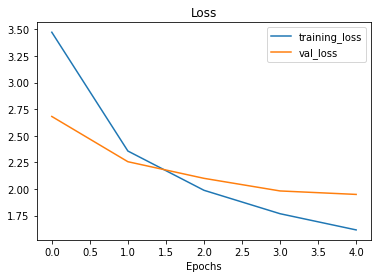

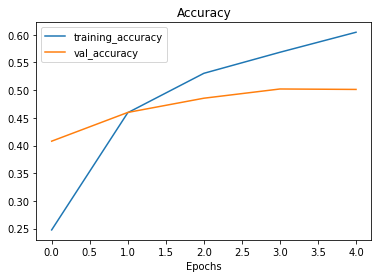

In [24]:
plot_loss_curves(base_model_history_101_food_classes_10_percent)

## Fine tuning

In [9]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [10]:
for i, layer in enumerate(base_model.layers[-10:]):
    print(i, layer.name, layer.trainable)
    

0 block7a_se_squeeze False
1 block7a_se_reshape False
2 block7a_se_reduce False
3 block7a_se_expand False
4 block7a_se_excite False
5 block7a_project_conv True
6 block7a_project_bn True
7 top_conv True
8 top_bn True
9 top_activation True


In [11]:
# Recompiling model with lower learning_rate
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [31]:
# Fit the model again
initial_epochs = 5
history_fine_tuned_base_model_101_food_classes_10_percent = model.fit(train_data_all_10_percent,
                                                                     epochs=initial_epochs + 5,
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)),
                                                                     initial_epoch=base_model_history_101_food_classes_10_percent.epoch[-1],
                                                                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning_scaling_up",
                                                                                                           experiment_name="history_fine_tuned_base_model_101_food_classes_10_percent")])

Saving TensorBoard log files to: transfer_learning_scaling_up/history_fine_tuned_base_model_101_food_classes_10_percent/20220618-142315
Epoch 5/10
237/237 [==============================] - 37s 139ms/step - loss: 1.3505 - accuracy: 0.6520 - val_loss: 1.9043 - val_accuracy: 0.5040
Epoch 6/10
237/237 [==============================] - 30s 125ms/step - loss: 1.2269 - accuracy: 0.6780 - val_loss: 1.8950 - val_accuracy: 0.5082
Epoch 7/10
237/237 [==============================] - 30s 125ms/step - loss: 1.1423 - accuracy: 0.6956 - val_loss: 1.8498 - val_accuracy: 0.5238
Epoch 8/10
237/237 [==============================] - 29s 123ms/step - loss: 1.0843 - accuracy: 0.7163 - val_loss: 1.8355 - val_accuracy: 0.5336
Epoch 9/10
237/237 [==============================] - 28s 119ms/step - loss: 1.0216 - accuracy: 0.7257 - val_loss: 1.8450 - val_accuracy: 0.5281
Epoch 10/10
237/237 [==============================] - 29s 122ms/step - loss: 0.9663 - accuracy: 0.7403 - val_loss: 1.8404 - val_accuracy: 

In [32]:
# Evaluate on whole dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 47s 59ms/step - loss: 1.6130 - accuracy: 0.5783


[1.6130224466323853, 0.5782970190048218]

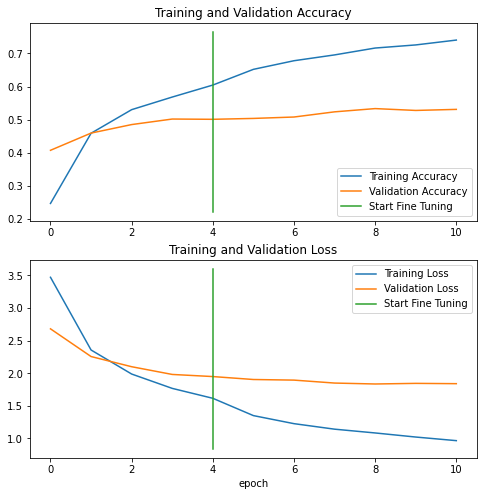

In [33]:
# Compare the histories with fine tuning
compare_historys(original_history=base_model_history_101_food_classes_10_percent,
                new_history=history_fine_tuned_base_model_101_food_classes_10_percent,
                initial_epochs=5)

## Saving and loading our model

to use it in extrenal applications

In [34]:
# Save our model

model.save("saved_model/101_food_classes-10_percent_saved_model")

INFO:tensorflow:Assets written to: saved_model/101_food_classes-10_percent_saved_model\assets


In [35]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("saved_model/101_food_classes-10_percent_saved_model")

In [36]:
# Evaluate loaded models
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 50s 62ms/step - loss: 1.6130 - accuracy: 0.5783


[1.6130224466323853, 0.5782970190048218]

In [37]:
# Model results before loading
all_classes_10_percent_fine_tune_results

[1.6130224466323853, 0.5782970190048218]

## Evaluating performace of model across all different classes

In [38]:
import tensorflow as tf

!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


Saved under 06_101_food_class_10_percent_saved_big_dog_model.zip


In [39]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [40]:
# Load in the model that was downloaded above
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [42]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 50s 63ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [43]:
all_classes_10_percent_fine_tune_results

[1.6130224466323853, 0.5782970190048218]

## Making perdictions with our trained model

In [44]:
# Make predictions with model
preds_probs =  model.predict(test_data, verbose=1) # set verbosity to see how log is left

790/790 [==============================] - 44s 55ms/step


In [45]:
# How many predictions are there
len(preds_probs)

25250

In [46]:
# Shapes of out predictions
preds_probs.shape

(25250, 101)

In [48]:
# let's see what first 10 predictions look like
preds_probs[:10]

array([[5.9542090e-02, 3.5742121e-06, 4.1376840e-02, ..., 1.4138681e-09,
        8.3530598e-05, 3.0897439e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286997e-05,
        7.8362204e-12, 9.8466213e-10],
       [9.5925879e-01, 3.2533557e-05, 1.4866907e-03, ..., 7.1891071e-07,
        5.4397321e-07, 4.0275892e-05],
       ...,
       [4.7313181e-01, 1.2931211e-07, 1.4805638e-03, ..., 5.9750059e-04,
        6.6969231e-05, 2.3469345e-05],
       [4.4571925e-02, 4.7265218e-07, 1.2258503e-01, ..., 6.3498333e-06,
        7.5318308e-06, 3.6778699e-03],
       [7.2438955e-01, 1.9249844e-09, 5.2311334e-05, ..., 1.2291443e-03,
        1.5792804e-09, 9.6396019e-05]], dtype=float32)

In [52]:
preds_probs[0], max(preds_probs[0]), sum(preds_probs[0])

(array([5.9542090e-02, 3.5742121e-06, 4.1376840e-02, 1.0660556e-09,
        8.1614289e-09, 8.6639496e-09, 8.0926901e-07, 8.5652584e-07,
        1.9858999e-05, 8.0977384e-07, 3.1727747e-09, 9.8673740e-07,
        2.8532202e-04, 7.8048756e-10, 7.4230059e-04, 3.8916307e-05,
        6.4740370e-06, 2.4977305e-06, 3.7891099e-05, 2.0678250e-07,
        1.5538410e-05, 8.1507187e-07, 2.6230518e-06, 2.0010687e-07,
        8.3827535e-07, 5.4215730e-06, 3.7391105e-06, 1.3150533e-08,
        2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574809e-05,
        1.6688897e-04, 7.6406859e-10, 4.0452785e-04, 1.3150658e-08,
        1.7957327e-06, 1.4448203e-06, 2.3062892e-02, 8.2466704e-07,
        8.5365542e-07, 1.7138564e-06, 7.0524907e-06, 1.8402202e-08,
        2.8553487e-07, 7.9483316e-06, 2.0681496e-06, 1.8525223e-07,
        3.3619582e-08, 3.1522481e-04, 1.0410963e-05, 8.5448289e-07,
        8.4741873e-01, 1.0555426e-05, 4.4094796e-07, 3.7404108e-05,
        3.5306195e-05, 3.2488948e-05, 6.7314621e

In [54]:
# we get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"Waht prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the heighest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
Waht prediction probability sample 0 looks like:
 [5.9542090e-02 3.5742121e-06 4.1376840e-02 1.0660556e-09 8.1614289e-09
 8.6639496e-09 8.0926901e-07 8.5652584e-07 1.9858999e-05 8.0977384e-07
 3.1727747e-09 9.8673740e-07 2.8532202e-04 7.8048756e-10 7.4230059e-04
 3.8916307e-05 6.4740370e-06 2.4977305e-06 3.7891099e-05 2.0678250e-07
 1.5538410e-05 8.1507187e-07 2.6230518e-06 2.0010687e-07 8.3827535e-07
 5.4215730e-06 3.7391105e-06 1.3150533e-08 2.7761499e-03 2.8051867e-05
 6.8562162e-10 2.5574809e-05 1.6688897e-04 7.6406859e-10 4.0452785e-04
 1.3150658e-08 1.7957327e-06 1.4448203e-06 2.3062892e-02 8.2466704e-07
 8.5365542e-07 1.7138564e-06 7.0524907e-06 1.8402202e-08 2.8553487e-07
 7.9483316e-06 2.0681496e-06 1.8525223e-07 3.3619582e-08 3.1522481e-04
 1.0410963e-05 8.5448289e-07 8.4741873e-01 1.0555426e-05 4.4094796e-07
 3.7404108e-05 3.5306195e-05 3.2488948e-05 6.7314621e-05 1.2852568e-08
 2.6219760e-10 1.0318091e-05 8.5744046e-05 1.

In [57]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [58]:
len(pred_classes)

25250

Now, compate pred_classes to test_data labels

In [61]:
# To get out test labels we need to unravel out test_data BatchDataset
y_label = []
for images, labels in test_data.unbatch():
    y_label.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 0, 1 ... , 0, 0]
    
y_label[:10] # look at first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [62]:
len(y_label)

25250

## Evaluating our model's predictions

In [63]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [64]:
# trying scikit-learn's accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_label, y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

## Making confusion matrix

In [69]:
from helper_functions import make_confusion_matrix

In [74]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#Need to make some changes in confusion matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # plotting x labels vertically
    plt.xticks(rotation=70, fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

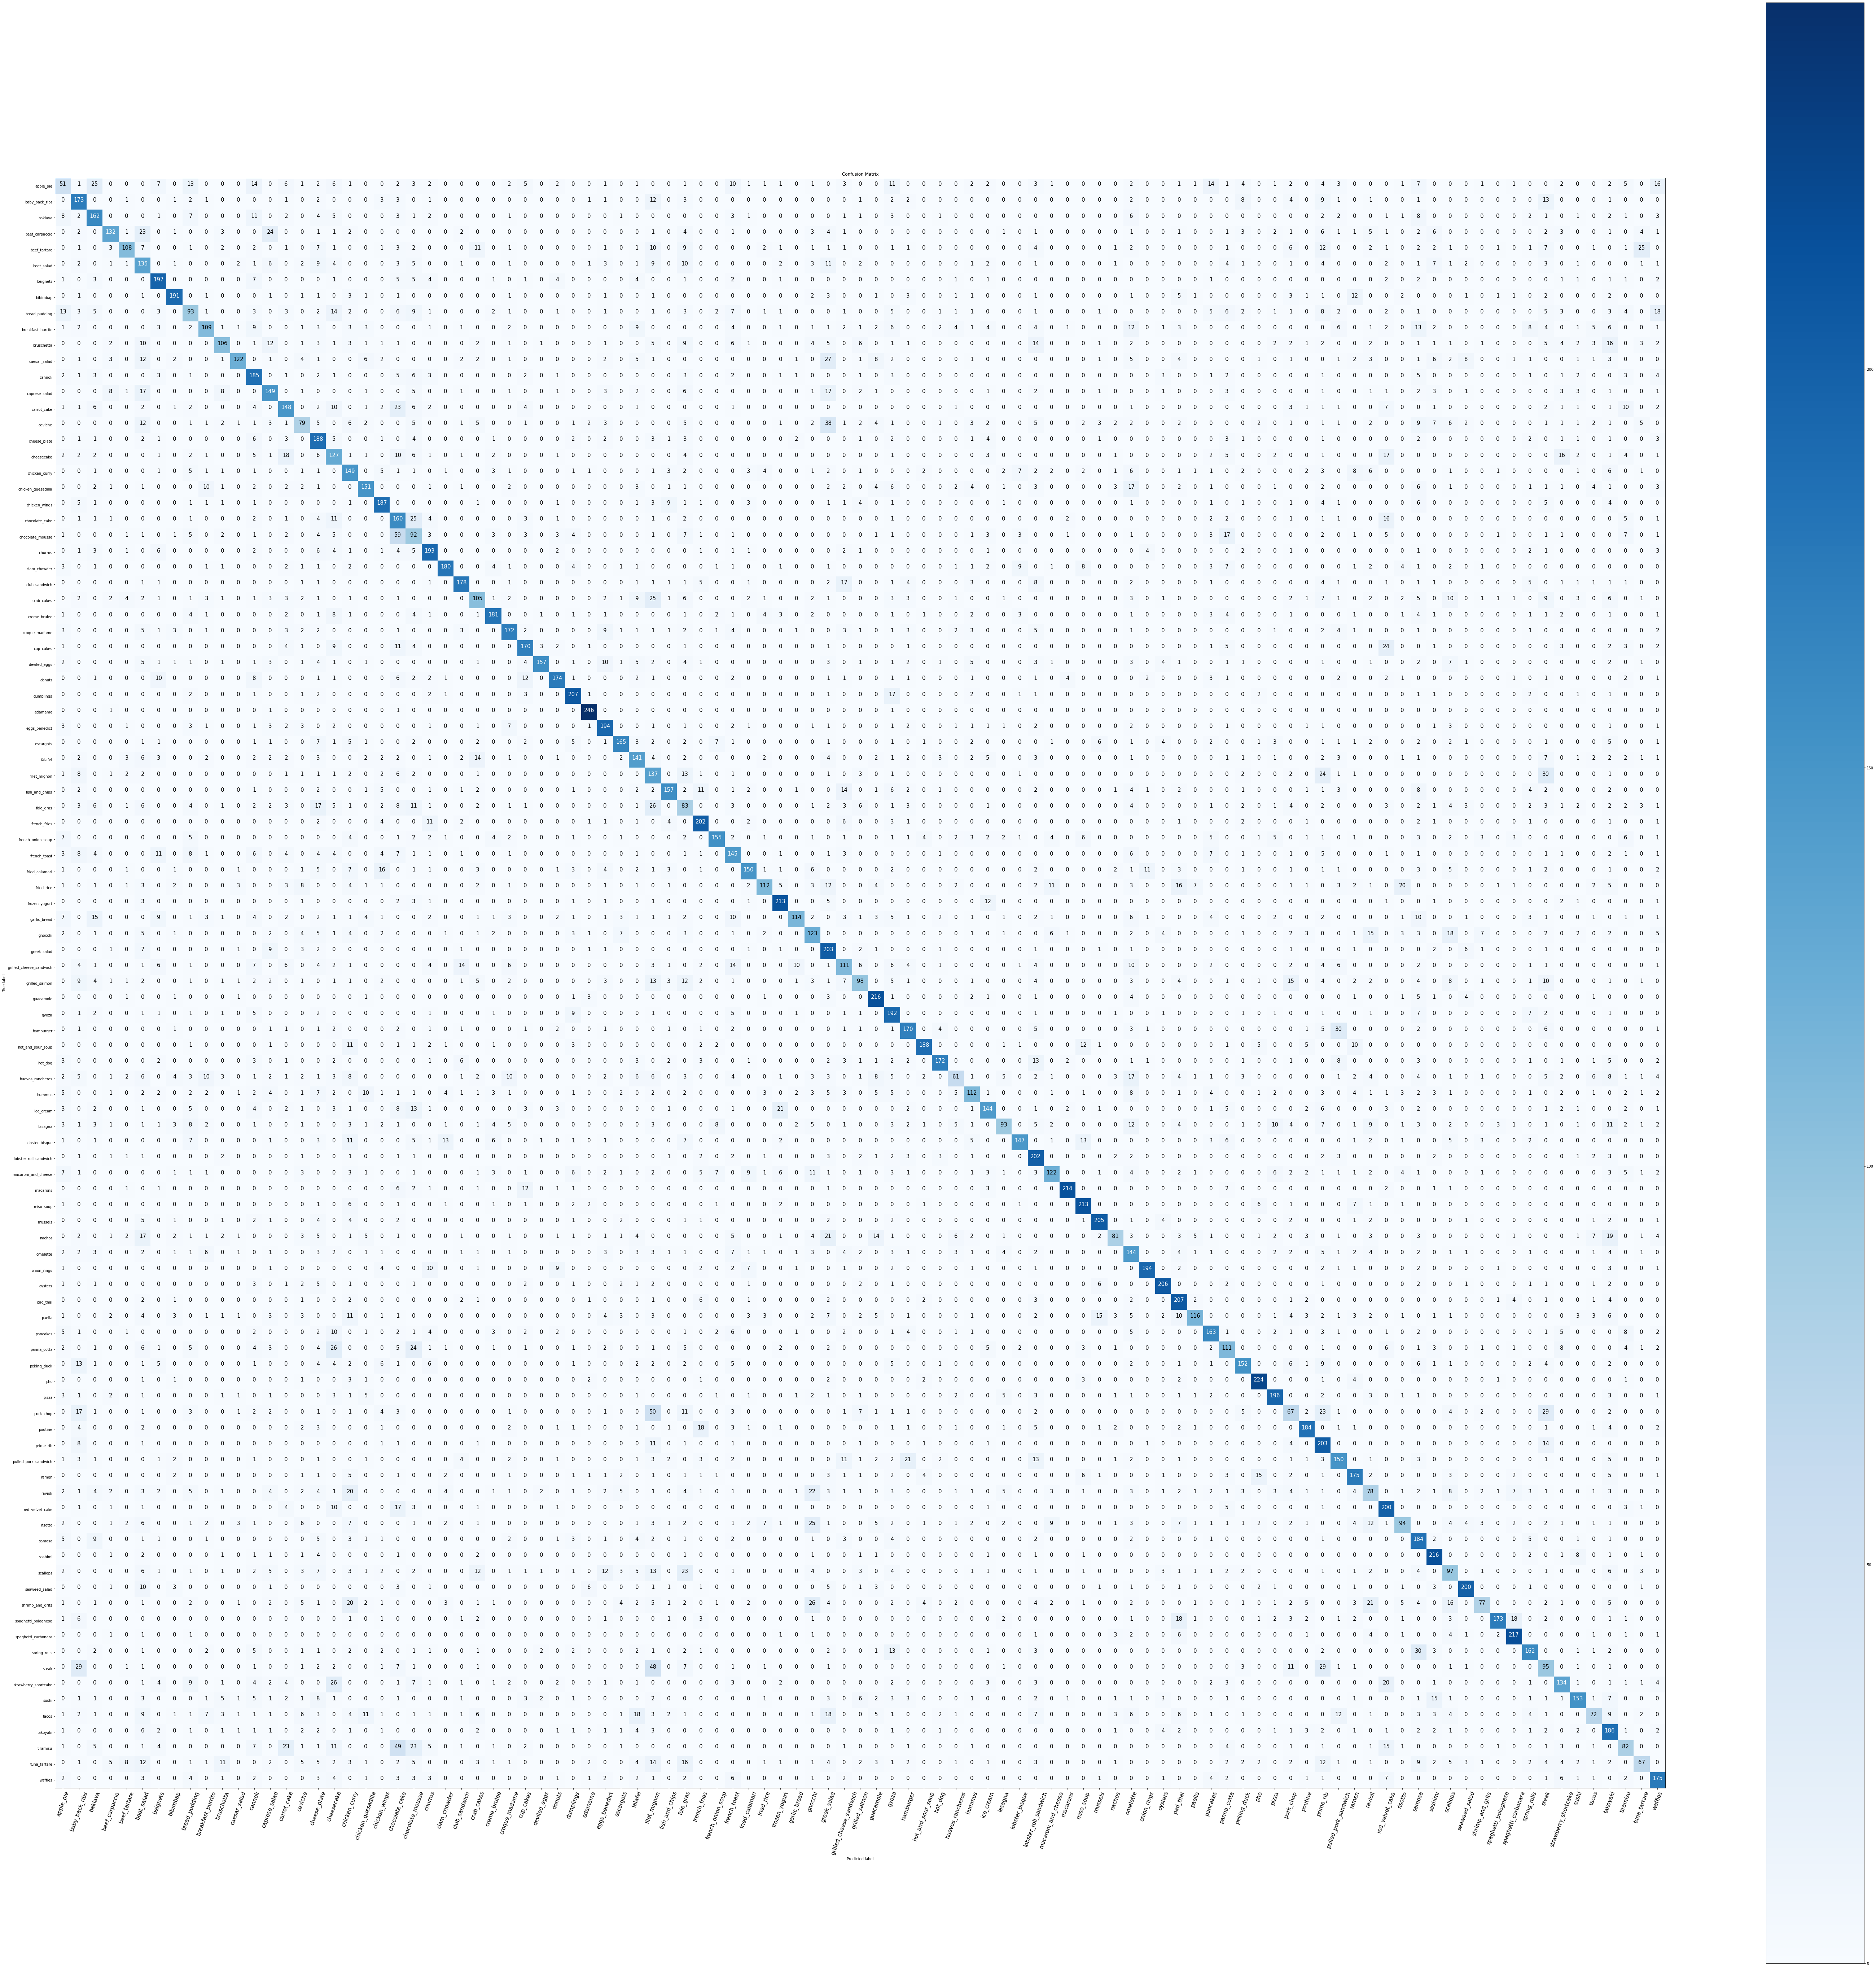

In [75]:
make_confusion_matrix(y_true=y_label, y_pred=pred_classes, classes=test_data.class_names, figsize=(100, 100))

## Creating classification report

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_label, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [80]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_true=y_label, y_pred=pred_classes, output_dict=True)

In [81]:
class_names = test_data.class_names

## Ploting F1 scores

In [83]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report
for k, v in classification_report_dict.items():
    if k == "accuracy": # Stop once we get to accuracy key
        break
    else:
        # Add class names and F1 scores o new dictionaty
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [86]:
# turn f1 scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [89]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

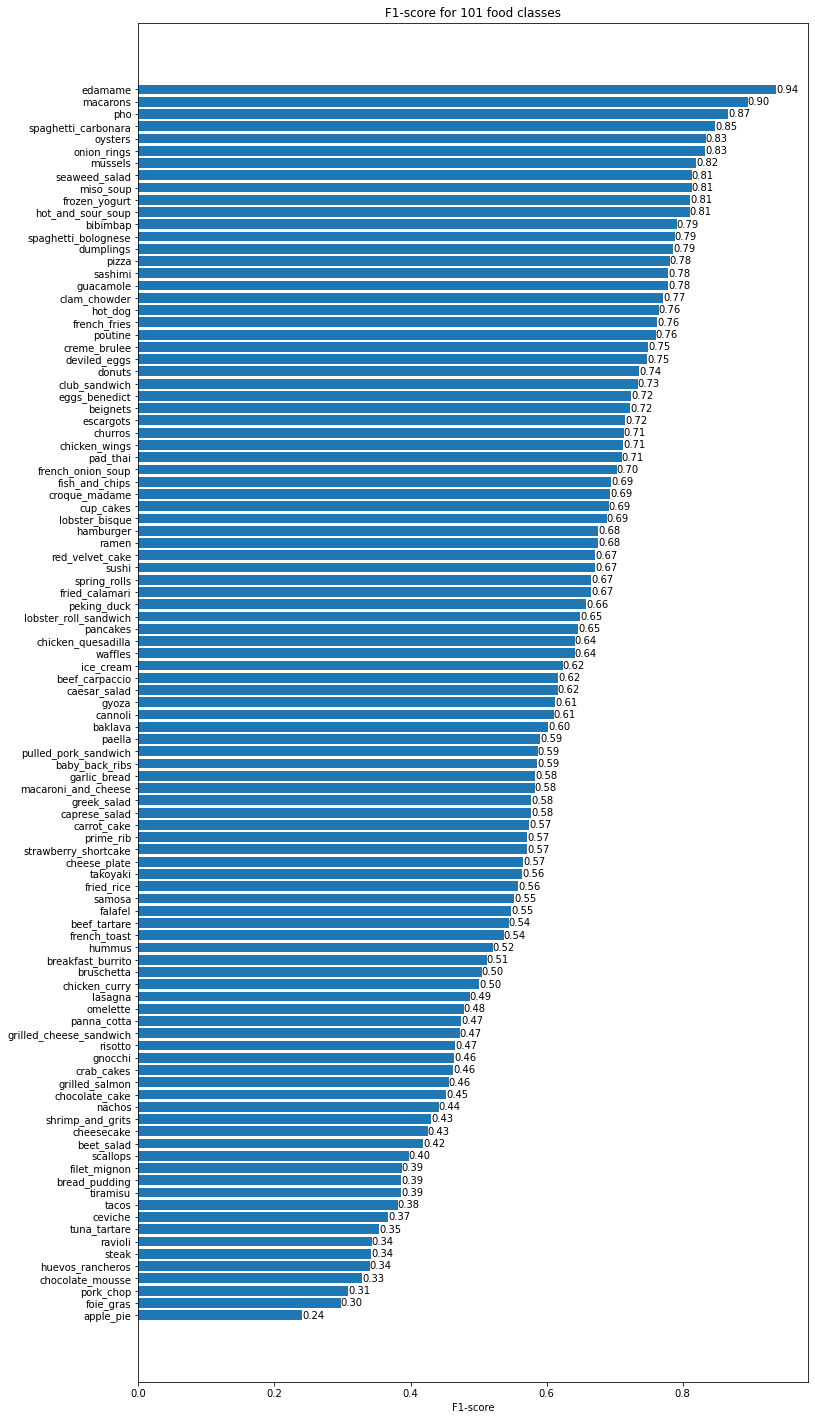

In [97]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 food classes")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

## Visualizing predictions on test images

Steps:
* Read in a target inmage filepath using tf.io.read_file()
* turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as images our model has trained on using tf.image.resize()
* Scale the image to get all of the pizel values between 0 & 1

In [98]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_size=224, scale=True):
    """
    reads in an image form filename, turns it into a tensor and reshapes into specified shape
    
    Args:
        filename (str): path to target image
        img_shape (int): height/width dimentions of target image size
        scale (bool): scale pixel values from 0-255 to  0-1 or not
        
    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename=filename)
    
    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)
    
    # Resize the image
    img = tf.image.resize(img, [img_size, img_size])
    
    # Scaling
    if scale:
        # Rescale the image
        return img/255.
    else:
        return img

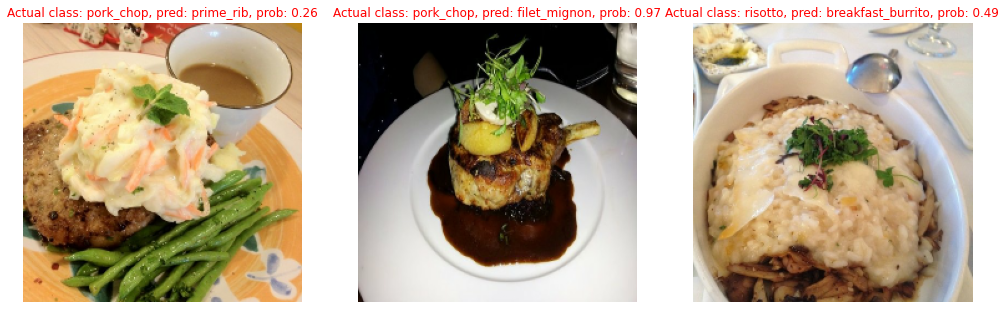

In [110]:
# visualize test images

# Make preds on series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename
    
    # Load the images and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded) # get perdiction probability array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
    
    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class: # if predicted class matches, truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual class: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);
    

## Finding the most wrong predictions

In [113]:
# get all of the files from test_data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
    
filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [114]:
# Create a dataframe of different parameters
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_label,
                       "y_pred": pred_classes,
                       "pred_conf": preds_probs.max(axis=1), # Get the maximum prediction probability value
                       "y_true_classname": [class_names[i] for i in y_label],
                       "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent\\test\\apple_pie...       0      52   
1      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100      16   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100      94   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658606        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537900          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [115]:
# Find which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      52   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658606        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [116]:
# Sort dataframe to have most wrong predictions at top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent\\test\\scallops\...      87      29   
231    b'101_food_classes_10_percent\\test\\apple_pie...       0     100   
15359  b'101_food_classes_10_percent\\test\\lobster_r...      61      53   
23539  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
21400  b'101_food_classes_10_percent\\test\\samosa\\3...      85      92   
24540  b'101_food_classes_10_percent\\test\\tiramisu\...      98      83   
2511   b'101_food_classes_10_percent\\test\\bruschett...      10      61   
5574   b'101_food_classes_10_percent\\test\\chocolate...      22      21   
17855  b'101_food_classes_10_percent\\test\\paella\\2...      71      65   
23797  b'101_food_classes_10_percent\\test\\sushi\\16...      95      86   
18001  b'101_food_classes_10_percent\\test\\pancakes\...      72      67   
11642  b'101_food_classes_10_percent\\test\\garlic_br...      46      10   
10847  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   
23631  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
1155   b'101_food_classes_10_percent\\test\\beef_tart...       4       5   
10854  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   
23904  b'101_food_classes_10_percent\\test\\sushi\\33...      95      86   
7316   b'101_food_classes_10_percent\\test\\cup_cakes...      29      83   
13144  b'101_food_classes_10_percent\\test\\gyoza\\31...      52      92   
10880  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

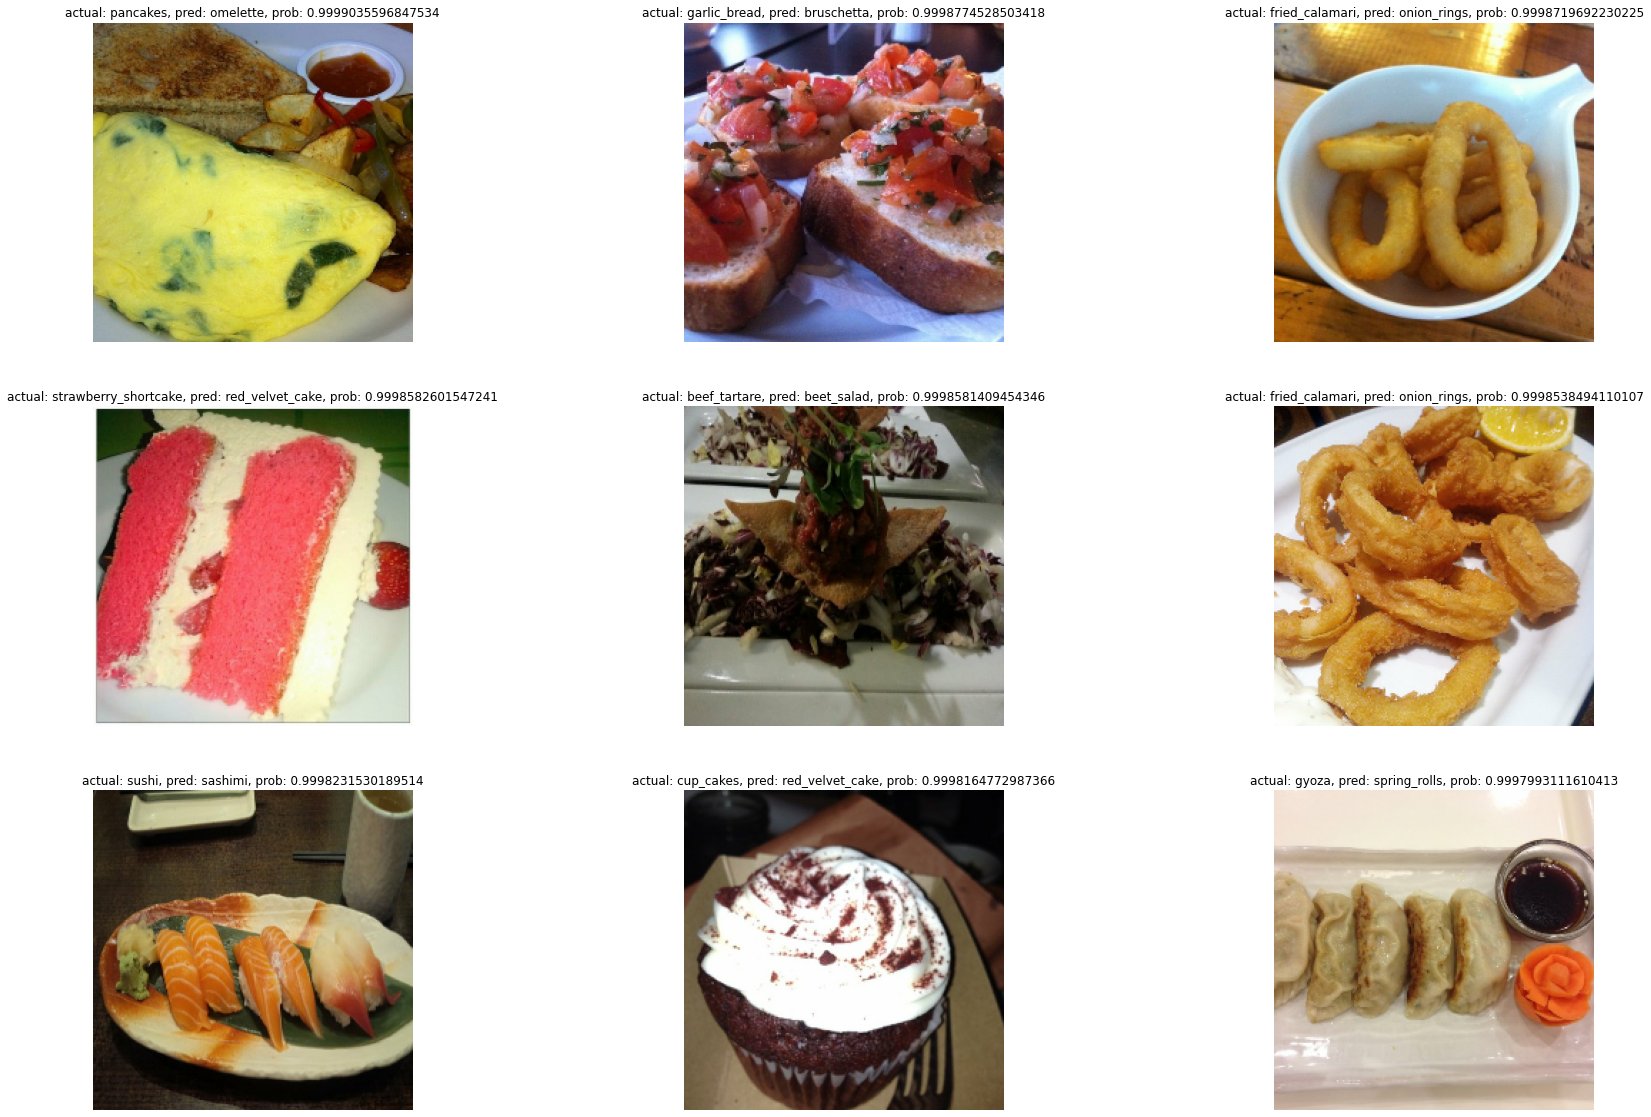

In [136]:
# Visualize wrong predictions
images_to_view = 9
start_index = 10
plt.figure(figsize=(30, 20))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # skipping few values
    plt.imshow(img/255)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, prob: {pred_prob}")
    plt.axis(False);
    

## Test model on custom images

In [137]:
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip


Saved under custom_food_images.zip


In [139]:
unzip_data("custom_food_images.zip")
walk_through_dir("custom_food_images")

There are 0 directories and 6 images in 'custom_food_images'.


In [143]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/samosa-recipe-500x500.jpg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

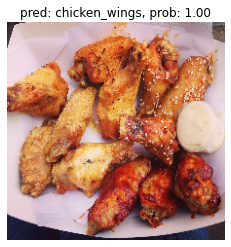

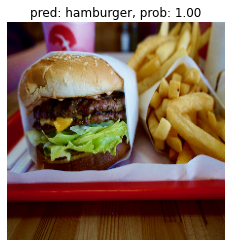

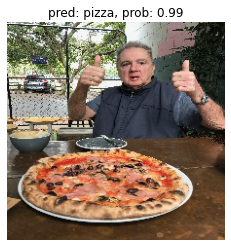

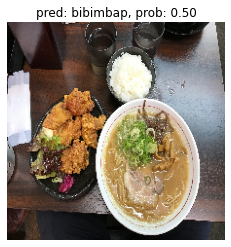

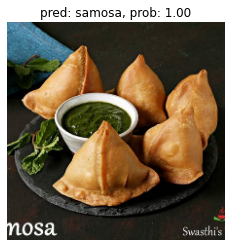

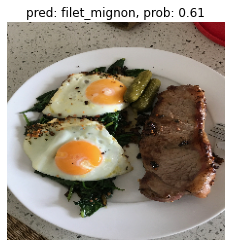

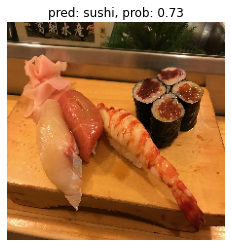

In [144]:
# make predictions and plot custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    
    # Plot the information
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False);